<a href="https://colab.research.google.com/github/neeluu876/nsf-hdr-ml-challenge-2026/blob/main/Monkeys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Activity Forecasting with Cross-Day Generalization

This notebook implements a multi-step neural forecasting model for μECoG data.
The focus is on predicting future neural activity while handling day-to-day
recording drift through normalization and delta-based prediction.

Environment Setup and Imports

In [5]:
!pip -q install timm torchinfo
import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Data Loading and Inspection

In [6]:
DATA_DIR = "/content"

print("Files in /content:")
for f in sorted(os.listdir(DATA_DIR)):
    if f.endswith(".npz"):
        print(" -", f)


Files in /content:
 - train_data_affi.npz
 - train_data_affi_2024-03-20_private.npz
 - train_data_beignet.npz
 - train_data_beignet_2022-06-01_private.npz
 - train_data_beignet_2022-06-02_private.npz


In [7]:
import numpy as np
import os

DATA_DIR = "/content"

def load_npz(path):
    z = np.load(path)
    arr = z[list(z.keys())[0]]
    return arr.astype(np.float32)

paths = {
    "affi_train": os.path.join(DATA_DIR, "train_data_affi.npz"),
    "affi_val":   os.path.join(DATA_DIR, "train_data_affi_2024-03-20_private.npz"),
    "be_train":   os.path.join(DATA_DIR, "train_data_beignet.npz"),
    "be_val1":    os.path.join(DATA_DIR, "train_data_beignet_2022-06-01_private.npz"),
    "be_val2":    os.path.join(DATA_DIR, "train_data_beignet_2022-06-02_private.npz"),
}

# sanity check: ensure files exist
for k, v in paths.items():
    print(k, "exists:", os.path.exists(v))

# Load
affi_train = load_npz(paths["affi_train"])
affi_val   = load_npz(paths["affi_val"])

be_train = load_npz(paths["be_train"])
be_val   = np.concatenate(
    [load_npz(paths["be_val1"]), load_npz(paths["be_val2"])],
    axis=0
)

print("affi_train:", affi_train.shape, "affi_val:", affi_val.shape)
print("be_train:",   be_train.shape,   "be_val:",   be_val.shape)


affi_train exists: True
affi_val exists: True
be_train exists: True
be_val1 exists: True
be_val2 exists: True
affi_train: (985, 20, 239, 9) affi_val: (162, 20, 239, 9)
be_train: (700, 20, 89, 9) be_val: (158, 20, 89, 9)


Dataset Construction and Normalization

In [8]:
class NeuralForecastDataset(Dataset):
    def __init__(self, data_np, init_steps=10, use_all_features=True, eps=1e-6):
        self.data = data_np.astype(np.float32)
        self.init_steps = init_steps
        self.use_all_features = use_all_features
        self.eps = eps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]  # (20,C,F)

        if not self.use_all_features:
            x = x[..., :1]  # only feature 0

        x_in  = x[:self.init_steps]      # (10,C,F')
        x_out = x[self.init_steps:]      # (10,C,F')

        mean = x_in.mean(axis=0, keepdims=True)           # (1,C,F')
        std  = x_in.std(axis=0, keepdims=True) + self.eps # (1,C,F')

        x_in_n  = (x_in  - mean) / std
        x_out_n = (x_out - mean) / std

        last = x_in_n[-1:]           # (1,C,F')
        y_delta = x_out_n - last     # (10,C,F')

        return (
            torch.from_numpy(x_in_n),    # (10,C,F')
            torch.from_numpy(y_delta),  # (10,C,F')
            torch.from_numpy(last),     # (1,C,F')
            torch.from_numpy(mean),     # (1,C,F')
            torch.from_numpy(std),      # (1,C,F')
        )


Model Architecture

In [9]:
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.15):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        y = self.conv1(x)
        y = y[..., :x.size(-1)]  # crop to keep length
        y = F.gelu(y)
        y = self.dropout(y)

        y = self.conv2(y)
        y = y[..., :x.size(-1)]
        y = F.gelu(y)
        y = self.dropout(y)

        res = x if self.downsample is None else self.downsample(x)
        return y + res

class TCNForecaster(nn.Module):
    def __init__(self, in_dim, hidden=512, levels=5, kernel_size=3, dropout=0.15):
        super().__init__()
        layers = []
        ch_in = in_dim
        for i in range(levels):
            dilation = 2**i
            layers.append(TemporalBlock(ch_in, hidden, kernel_size=kernel_size, dilation=dilation, dropout=dropout))
            ch_in = hidden
        self.net = nn.Sequential(*layers)
        self.head = nn.Conv1d(hidden, in_dim, kernel_size=1)

    def forward(self, x):
        # x: (B,10,D)
        x = x.transpose(1,2)   # (B,D,10)
        y = self.net(x)        # (B,H,10)
        y = self.head(y)       # (B,D,10)
        return y.transpose(1,2)  # (B,10,D)


In [10]:
def train_one_epoch(model, loader, opt):
    model.train()
    total = 0.0
    for x_in, y_delta, last, mean, std in loader:
        x_in = x_in.to(device)
        y_delta = y_delta.to(device)

        B,T,C,Fdim = x_in.shape
        x_flat = x_in.reshape(B, T, C*Fdim)
        y_flat = y_delta.reshape(B, T, C*Fdim)

        pred = model(x_flat)
        loss = F.mse_loss(pred, y_flat)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        total += loss.item()

    return total / max(1, len(loader))

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total = 0.0
    for x_in, y_delta, last, mean, std in loader:
        x_in = x_in.to(device)
        y_delta = y_delta.to(device)

        B,T,C,Fdim = x_in.shape
        x_flat = x_in.reshape(B, T, C*Fdim)
        y_flat = y_delta.reshape(B, T, C*Fdim)

        pred = model(x_flat)
        loss = F.mse_loss(pred, y_flat)
        total += loss.item()

    return total / max(1, len(loader))

@torch.no_grad()
def future_feature0_mse(model, loader):
    model.eval()
    total = 0.0
    count = 0

    for x_in, y_delta, last, mean, std in loader:
        x_in = x_in.to(device)
        y_delta = y_delta.to(device)
        last = last.to(device)
        mean = mean.to(device)
        std = std.to(device)

        B,T,C,Fdim = x_in.shape
        x_flat = x_in.reshape(B, T, C*Fdim)

        pred_delta = model(x_flat).reshape(B, T, C, Fdim)
        pred_future_n = last + pred_delta
        true_future_n = last + y_delta

        pred_future = pred_future_n * std + mean
        true_future = true_future_n * std + mean

        pred0 = pred_future[..., 0]  # (B,10,C)
        true0 = true_future[..., 0]

        total += F.mse_loss(pred0, true0, reduction="sum").item()
        count += pred0.numel()

    return total / count


Training Model

In [11]:
def train_model(monkey_name, train_np, val_np, use_all_features=True,
                epochs=60, batch_size=32, hidden=512, levels=5, lr=2e-4, wd=1e-4, dropout=0.15):

    init_steps = 10
    train_ds = NeuralForecastDataset(train_np, init_steps=init_steps, use_all_features=use_all_features)
    val_ds   = NeuralForecastDataset(val_np,   init_steps=init_steps, use_all_features=use_all_features)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    # infer dims
    x0, *_ = train_ds[0]
    C = x0.shape[1]
    Fdim = x0.shape[2]
    D = C * Fdim

    model = TCNForecaster(in_dim=D, hidden=hidden, levels=levels, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    save_path = f"tcn_{monkey_name}.pth"
    best = float("inf")

    for ep in range(epochs):
        tr = train_one_epoch(model, train_loader, opt)
        va = eval_one_epoch(model, val_loader)
        va_f0 = future_feature0_mse(model, val_loader)
        sched.step()

        if va_f0 < best:
            best = va_f0
            torch.save({
                "state_dict": model.state_dict(),
                "monkey_name": monkey_name,
                "use_all_features": use_all_features,
                "init_steps": init_steps,
                "trained_C": C,
                "trained_Fdim": Fdim,
                "trained_D": D,
                "hidden": hidden,
                "levels": levels,
                "dropout": dropout,
            }, save_path)

        if ep % 5 == 0 or ep == epochs-1:
            print(f"[{monkey_name}] ep {ep:02d} train_mse(delta)={tr:.6f} "
                  f"val_mse(delta)={va:.6f} val_future_f0_mse={va_f0:.6f} best={best:.6f}")

    print("Saved best:", save_path)
    return save_path


Cross-Day Validation and Evaluation

In [12]:
be_ckpt = train_model(
    monkey_name="beignet",
    train_np=be_train,
    val_np=be_val,
    use_all_features=True,
    epochs=60,
    batch_size=32,
    hidden=512,
    levels=5,
    lr=2e-4,
    wd=1e-4,
    dropout=0.15
)


[beignet] ep 00 train_mse(delta)=11.593425 val_mse(delta)=18.320491 val_future_f0_mse=69335.376248 best=69335.376248
[beignet] ep 05 train_mse(delta)=10.279525 val_mse(delta)=18.500814 val_future_f0_mse=65527.809529 best=64284.581994
[beignet] ep 10 train_mse(delta)=8.922136 val_mse(delta)=18.670358 val_future_f0_mse=66934.981198 best=64284.581994
[beignet] ep 15 train_mse(delta)=8.136868 val_mse(delta)=18.836552 val_future_f0_mse=72175.719186 best=64284.581994
[beignet] ep 20 train_mse(delta)=7.585417 val_mse(delta)=18.871384 val_future_f0_mse=70289.116427 best=64284.581994
[beignet] ep 25 train_mse(delta)=7.116636 val_mse(delta)=18.883833 val_future_f0_mse=71704.846309 best=64284.581994
[beignet] ep 30 train_mse(delta)=6.782203 val_mse(delta)=18.883738 val_future_f0_mse=69030.605718 best=64284.581994
[beignet] ep 35 train_mse(delta)=6.487130 val_mse(delta)=18.903226 val_future_f0_mse=70240.292192 best=64284.581994
[beignet] ep 40 train_mse(delta)=6.283381 val_mse(delta)=18.884682 val

In [13]:
affi_ckpt = train_model(
    monkey_name="affi",
    train_np=affi_train,
    val_np=affi_val,
    use_all_features=True,
    epochs=60,
    batch_size=16,   # smaller to avoid OOM
    hidden=512,
    levels=5,
    lr=2e-4,
    wd=1e-4,
    dropout=0.15
)


[affi] ep 00 train_mse(delta)=13.743233 val_mse(delta)=13.792336 val_future_f0_mse=73359.880490 best=73359.880490
[affi] ep 05 train_mse(delta)=11.742510 val_mse(delta)=14.063166 val_future_f0_mse=55661.224815 best=55661.224815
[affi] ep 10 train_mse(delta)=10.307307 val_mse(delta)=14.226282 val_future_f0_mse=58194.635673 best=55661.224815
[affi] ep 15 train_mse(delta)=9.177624 val_mse(delta)=14.577846 val_future_f0_mse=64589.742859 best=55661.224815
[affi] ep 20 train_mse(delta)=8.306676 val_mse(delta)=14.347713 val_future_f0_mse=62994.427398 best=55661.224815
[affi] ep 25 train_mse(delta)=7.599786 val_mse(delta)=14.352043 val_future_f0_mse=61928.202407 best=55661.224815
[affi] ep 30 train_mse(delta)=7.139374 val_mse(delta)=14.389039 val_future_f0_mse=59117.050261 best=55661.224815
[affi] ep 35 train_mse(delta)=6.672777 val_mse(delta)=14.443925 val_future_f0_mse=63060.410310 best=55661.224815
[affi] ep 40 train_mse(delta)=6.411727 val_mse(delta)=14.421672 val_future_f0_mse=58728.19844

Results and Discussion

In [14]:
%%writefile model.py
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.0):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        y = self.conv1(x)
        y = y[..., :x.size(-1)]
        y = F.gelu(y)
        y = self.dropout(y)

        y = self.conv2(y)
        y = y[..., :x.size(-1)]
        y = F.gelu(y)
        y = self.dropout(y)

        res = x if self.downsample is None else self.downsample(x)
        return y + res

class TCNForecaster(nn.Module):
    def __init__(self, in_dim, hidden=512, levels=5, kernel_size=3, dropout=0.0):
        super().__init__()
        layers = []
        ch_in = in_dim
        for i in range(levels):
            dilation = 2**i
            layers.append(TemporalBlock(ch_in, hidden, kernel_size=kernel_size, dilation=dilation, dropout=dropout))
            ch_in = hidden
        self.net = nn.Sequential(*layers)
        self.head = nn.Conv1d(hidden, in_dim, kernel_size=1)

    def forward(self, x):
        x = x.transpose(1,2)   # (B,D,10)
        y = self.net(x)
        y = self.head(y)
        return y.transpose(1,2)  # (B,10,D)

def _normalize_per_sample(x_in, eps=1e-6):
    # x_in: (N,10,C,F)
    mean = x_in.mean(axis=1, keepdims=True)  # (N,1,C,F)
    std  = x_in.std(axis=1, keepdims=True) + eps
    return (x_in - mean) / std, mean, std

class Model:
    def __init__(self, monkey_name=""):
        self.monkey_name = monkey_name
        self.init_steps = 10
        self.use_all_features = True
        self.model = None
        self.trained_C = None
        self.trained_Fdim = None

    def load(self):
        if self.monkey_name == "affi":
            w = "tcn_affi.pth"
        elif self.monkey_name == "beignet":
            w = "tcn_beignet.pth"
        else:
            raise ValueError(f"No such monkey: {self.monkey_name}")

        path = os.path.join(os.path.dirname(__file__), w)
        ckpt = torch.load(path, map_location="cpu")

        self.trained_C = int(ckpt["trained_C"])
        self.trained_Fdim = int(ckpt["trained_Fdim"])
        D = int(ckpt["trained_D"])
        hidden = int(ckpt.get("hidden", 512))
        levels = int(ckpt.get("levels", 5))

        self.model = TCNForecaster(in_dim=D, hidden=hidden, levels=levels, dropout=0.0).to(DEVICE)
        self.model.load_state_dict(ckpt["state_dict"], strict=True)
        self.model.eval()

    @torch.no_grad()
    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        N,T,C_in,F_in = X.shape
        if T != 20:
            raise ValueError("Expected 20 time steps")

        out = np.zeros((N, 20, C_in), dtype=np.float32)
        out[:, :10, :] = X[:, :10, :, 0]      # copy observed
        out[:, 10:, :] = X[:, 9:10, :, 0]     # fallback persistence

        if self.use_all_features:
            Xf = X
        else:
            Xf = X[..., :1]

        C_common = min(C_in, self.trained_C)

        x_in = Xf[:, :10, :C_common, :self.trained_Fdim]  # (N,10,C,F')
        x_in_n, mean, std = _normalize_per_sample(x_in)

        last = x_in_n[:, -1:, :, :]  # (N,1,C,F')
        Nn,_,Cc,Fc = x_in_n.shape

        x_flat = torch.from_numpy(x_in_n).to(DEVICE).reshape(Nn, 10, Cc*Fc)
        pred_delta = self.model(x_flat).reshape(Nn, 10, Cc, Fc).cpu().numpy()

        pred_future_n = last + pred_delta
        pred_future = pred_future_n * std + mean

        out[:, 10:, :C_common] = pred_future[..., 0]
        return out


Writing model.py


Using device: cuda
[beignet] loaded tcn_beignet.pth | D=801 (C=89, F=9) | hidden=512 levels=5 dropout=0.15
[affi] loaded tcn_affi.pth | D=2151 (C=239, F=9) | hidden=512 levels=5 dropout=0.15
Beignet overall future feature0 MSE: 64284.581994026456
Affi overall future feature0 MSE: 55661.22481533137


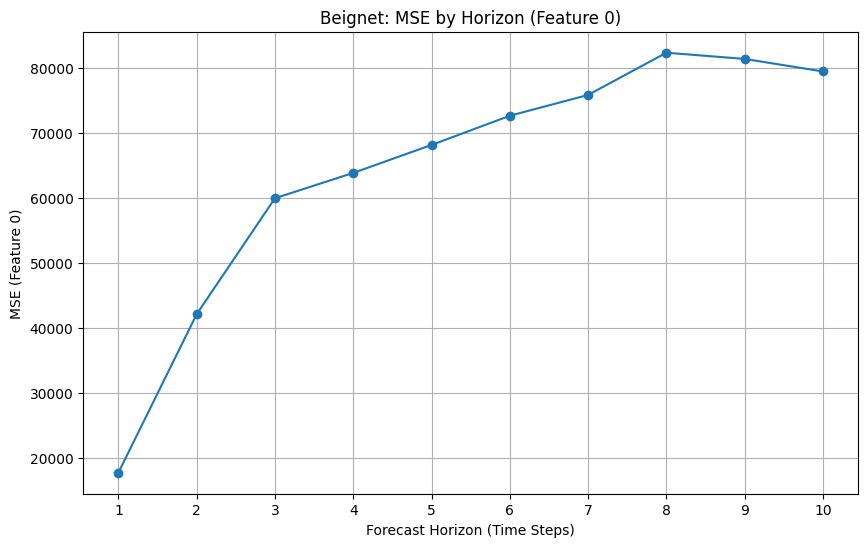

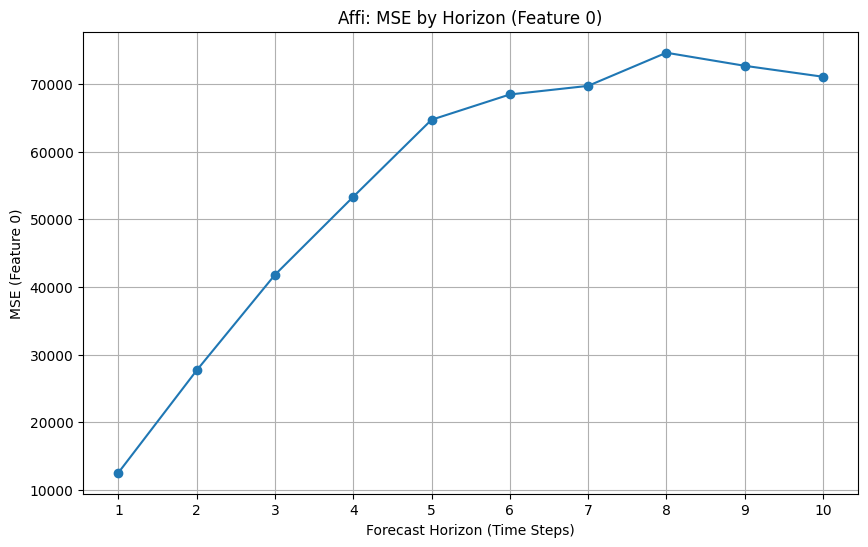

In [16]:
import torch
from torch.utils.data import DataLoader
import os
import numpy as np # Added import for numpy
import torch.nn.functional as F # Added import for functional API
import matplotlib.pyplot as plt # Added import for plotting

# ----- device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----- metrics functions (moved/defined here) -----
@torch.no_grad()
def overall_future_feature0_mse(model, loader):
    model.eval()
    total = 0.0
    count = 0

    for x_in, y_delta, last, mean, std in loader:
        x_in = x_in.to(device)
        y_delta = y_delta.to(device)
        last = last.to(device)
        mean = mean.to(device)
        std = std.to(device)

        B,T,C,Fdim = x_in.shape
        x_flat = x_in.reshape(B, T, C*Fdim)

        pred_delta = model(x_flat).reshape(B, T, C, Fdim)
        pred_future_n = last + pred_delta
        true_future_n = last + y_delta

        pred_future = pred_future_n * std + mean
        true_future = true_future_n * std + mean

        pred0 = pred_future[..., 0]  # (B,10,C)
        true0 = true_future[..., 0]

        total += F.mse_loss(pred0, true0, reduction="sum").item()
        count += pred0.numel()

    return total / count

@torch.no_grad()
def mse_by_horizon(model, loader):
    model.eval()
    mse_per_horizon = torch.zeros(10).to(device)
    count_per_horizon = torch.zeros(10).to(device)

    for x_in, y_delta, last, mean, std in loader:
        x_in = x_in.to(device)
        y_delta = y_delta.to(device)
        last = last.to(device)
        mean = mean.to(device)
        std = std.to(device)

        B,T,C,Fdim = x_in.shape
        x_flat = x_in.reshape(B, T, C*Fdim)

        pred_delta = model(x_flat).reshape(B, T, C, Fdim)
        pred_future_n = last + pred_delta
        true_future_n = last + y_delta

        pred_future = pred_future_n * std + mean
        true_future = true_future_n * std + mean

        pred0 = pred_future[..., 0]  # (B,10,C)
        true0 = true_future[..., 0]

        for h in range(10): # Iterate over the 10 future steps
            mse_per_horizon[h] += F.mse_loss(pred0[:, h, :], true0[:, h, :], reduction="sum").item()
            count_per_horizon[h] += pred0[:, h, :].numel()

    # Avoid division by zero
    mse_per_horizon = mse_per_horizon / torch.max(count_per_horizon, torch.tensor(1.0).to(device))
    return mse_per_horizon.cpu().numpy()

def plot_horizon_curve(horizon_mses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, 11), horizon_mses, marker='o')
    plt.title(title)
    plt.xlabel("Forecast Horizon (Time Steps)")
    plt.ylabel("MSE (Feature 0)")
    plt.xticks(np.arange(1, 11))
    plt.grid(True)
    plt.show()


# ----- helper: load checkpoint and build model exactly as trained -----
def load_model_for_monkey(monkey_name, ckpt_path):
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}\n"
                                f"Check the left Colab file panel for the exact filename.")

    ckpt = torch.load(ckpt_path, map_location=device)

    # Your checkpoints were saved as dicts with keys like:
    # state_dict, monkey_name, use_all_features, init_steps, trained_C, trained_Fdim, trained_D, hidden, levels, dropout
    state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    hidden = ckpt.get("hidden", 512) if isinstance(ckpt, dict) else 512
    levels = ckpt.get("levels", 5) if isinstance(ckpt, dict) else 5
    dropout = ckpt.get("dropout", 0.15) if isinstance(ckpt, dict) else 0.15
    init_steps = ckpt.get("init_steps", 10) if isinstance(ckpt, dict) else 10
    use_all_features = ckpt.get("use_all_features", True) if isinstance(ckpt, dict) else True

    # pick correct validation array
    data = be_val if monkey_name == "beignet" else affi_val

    # build dataset to infer input dims
    ds = NeuralForecastDataset(data, init_steps=init_steps, use_all_features=use_all_features)
    x_in, *_ = ds[0]  # x_in shape: (10, C, F) in your dataset
    C = x_in.shape[1]
    Fdim = x_in.shape[2]
    D = C * Fdim

    # build model with same hyperparams
    model = TCNForecaster(in_dim=D, hidden=hidden, levels=levels, dropout=dropout).to(device)
    model.load_state_dict(state, strict=True)
    model.eval()

    print(f"[{monkey_name}] loaded {ckpt_path} | D={D} (C={C}, F={Fdim}) | hidden={hidden} levels={levels} dropout={dropout}")
    return model, ds, init_steps, use_all_features

# ----- loaders -----
# Use init_steps/use_all_features consistent with how you trained (your checkpoints store these; we also build ds there)
be_model, be_val_ds, _, _ = load_model_for_monkey("beignet", "tcn_beignet.pth")
affi_model, affi_val_ds, _, _ = load_model_for_monkey("affi", "tcn_affi.pth")

be_val_loader = DataLoader(be_val_ds, batch_size=64, shuffle=False, num_workers=2)
affi_val_loader = DataLoader(affi_val_ds, batch_size=64, shuffle=False, num_workers=2)

# ----- metrics -----
be_mse = overall_future_feature0_mse(be_model, be_val_loader)
affi_mse = overall_future_feature0_mse(affi_model, affi_val_loader)

print("Beignet overall future feature0 MSE:", be_mse)
print("Affi overall future feature0 MSE:", affi_mse)

be_h = mse_by_horizon(be_model, be_val_loader)
affi_h = mse_by_horizon(affi_model, affi_val_loader)

plot_horizon_curve(be_h, "Beignet: MSE by Horizon (Feature 0)")
plot_horizon_curve(affi_h, "Affi: MSE by Horizon (Feature 0)")

Beignet overall future feature0 MSE: 64284.581994026456
Affi overall future feature0 MSE: 55661.22481533137


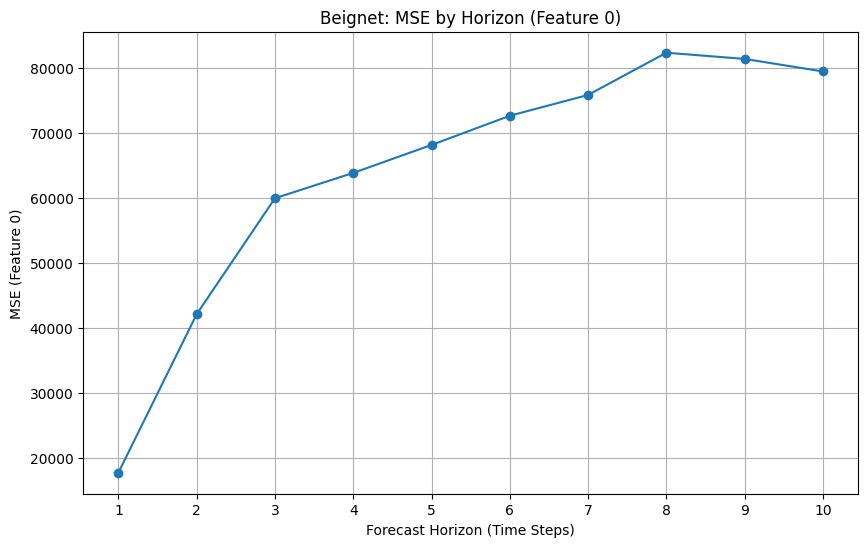

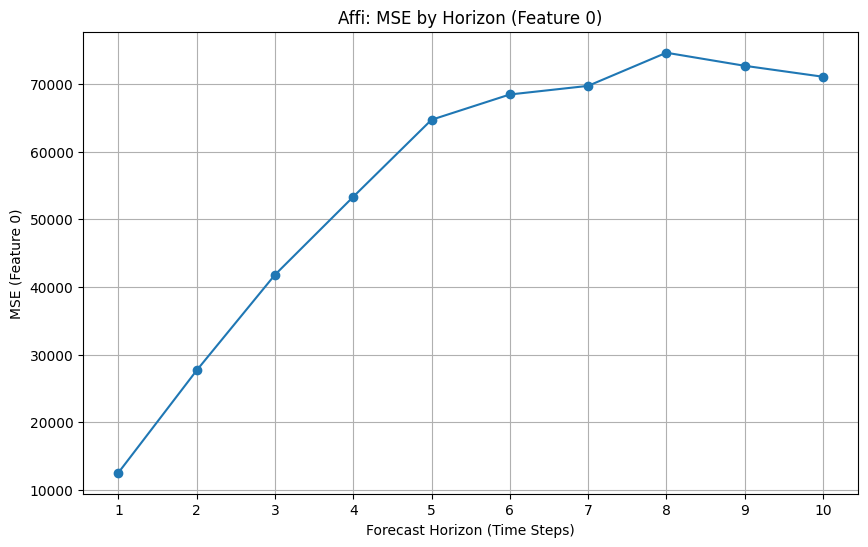

In [18]:
# Load the best saved model weights and evaluate

def load_model_for_monkey(monkey_name, ckpt_path):
    # Load the full checkpoint dictionary
    ckpt = torch.load(ckpt_path, map_location=device)

    # Extract hyperparameters from the checkpoint
    hidden = ckpt.get("hidden", 512)
    levels = ckpt.get("levels", 5)
    dropout = ckpt.get("dropout", 0.15)
    init_steps = ckpt.get("init_steps", 10)
    use_all_features = ckpt.get("use_all_features", True)

    # infer dims from dataset, ensuring consistency with training
    if monkey_name == "beignet":
        ds = NeuralForecastDataset(be_val, init_steps=init_steps, use_all_features=use_all_features)
    else:
        ds = NeuralForecastDataset(affi_val, init_steps=init_steps, use_all_features=use_all_features)

    x_in, *_ = ds[0]
    C = x_in.shape[1]
    Fdim = x_in.shape[2]
    D = C * Fdim

    model = TCNForecaster(in_dim=D, hidden=hidden, levels=levels, dropout=dropout).to(device)
    # Load only the 'state_dict' part of the checkpoint
    model.load_state_dict(ckpt["state_dict"], strict=True)
    model.eval()
    return model, ds

# Build loaders (use the same batch sizes as your training)
be_val_ds = NeuralForecastDataset(be_val, init_steps=10, use_all_features=True)
affi_val_ds = NeuralForecastDataset(affi_val, init_steps=10, use_all_features=True)

be_val_loader = DataLoader(be_val_ds, batch_size=64, shuffle=False, num_workers=2)
affi_val_loader = DataLoader(affi_val_ds, batch_size=64, shuffle=False, num_workers=2)

# Load models
be_model, _ = load_model_for_monkey("beignet", "tcn_beignet.pth")
affi_model, _ = load_model_for_monkey("affi", "tcn_affi.pth")

# Overall future feature0 MSE
be_mse = overall_future_feature0_mse(be_model, be_val_loader)
affi_mse = overall_future_feature0_mse(affi_model, affi_val_loader)

print("Beignet overall future feature0 MSE:", be_mse)
print("Affi overall future feature0 MSE:", affi_mse)

# Horizon curves
be_h = mse_by_horizon(be_model, be_val_loader)
affi_h = mse_by_horizon(affi_model, affi_val_loader)

plot_horizon_curve(be_h, "Beignet: MSE by Horizon (Feature 0)")
plot_horizon_curve(affi_h, "Affi: MSE by Horizon (Feature 0)")

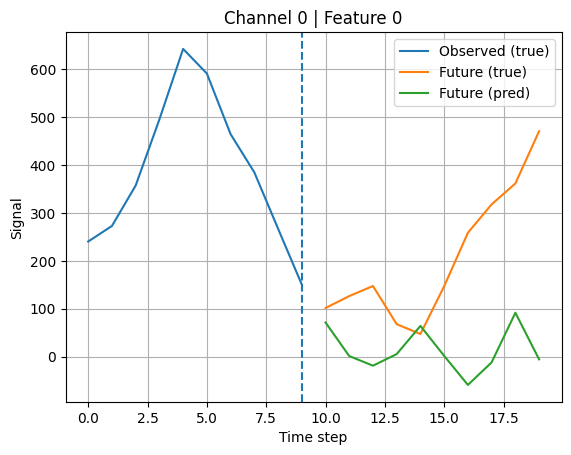

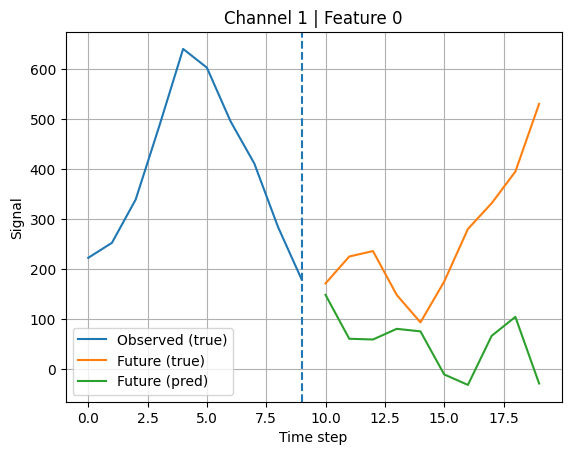

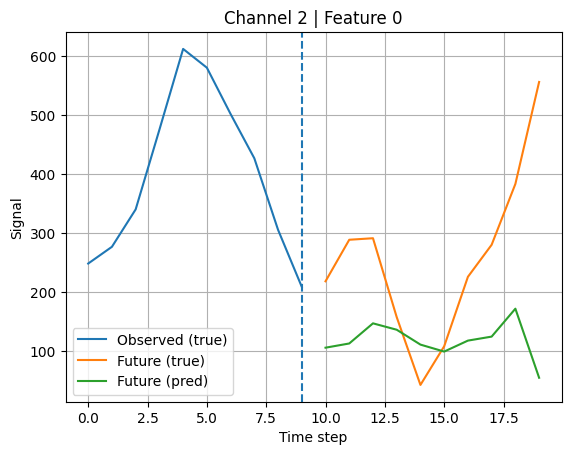

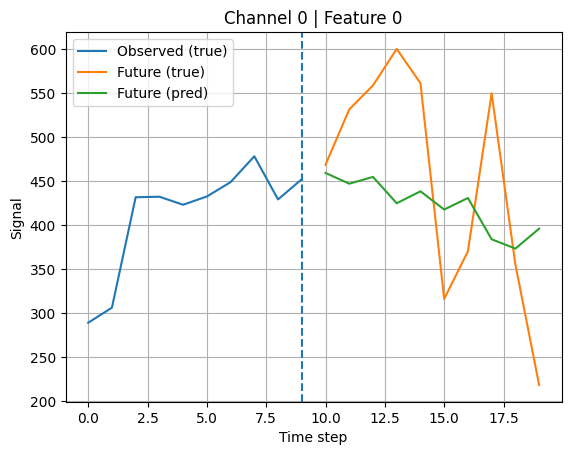

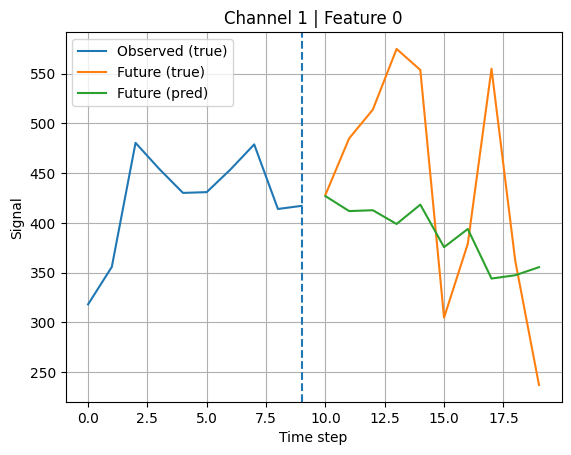

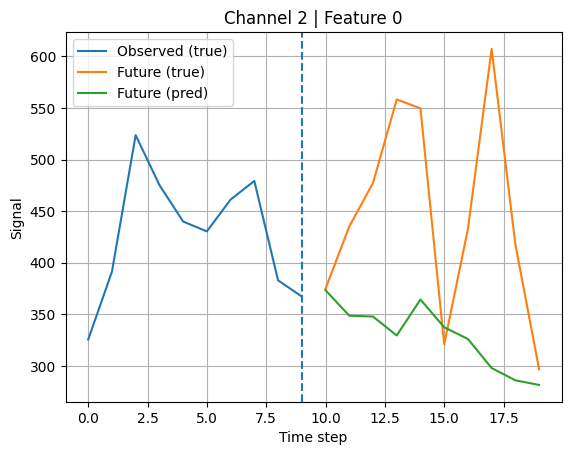

In [19]:
@torch.no_grad()
def plot_predictions_for_sample(model, dataset, sample_idx=0, channels=(0,1,2), feature_idx=0):
    model.eval()

    x_in, y_delta, last, mean, std = dataset[sample_idx]
    # x_in: (10,C,F), y_delta: (10,C,F)
    x_in = x_in.unsqueeze(0).to(device)       # (1,10,C,F)
    y_delta = y_delta.unsqueeze(0).to(device)
    last = last.unsqueeze(0).to(device)       # (1,10,C,F)
    mean = mean.unsqueeze(0).to(device)
    std = std.unsqueeze(0).to(device)

    B,T,C,Fdim = x_in.shape
    x_flat = x_in.reshape(B, T, C*Fdim)

    pred_delta = model(x_flat).reshape(B, T, C, Fdim)

    # denorm observed (first 10)
    obs = x_in * std + mean  # (1,10,C,F)

    # denorm future
    pred_future = (last + pred_delta) * std + mean
    true_future = (last + y_delta) * std + mean

    # build full 20 steps for plotting (obs + future)
    pred_full = torch.cat([obs, pred_future], dim=1)[0, :, :, feature_idx].cpu().numpy()  # (20,C)
    true_full = torch.cat([obs, true_future], dim=1)[0, :, :, feature_idx].cpu().numpy()  # (20,C)

    t = np.arange(20)

    for ch in channels:
        plt.figure()
        plt.plot(t[:10], true_full[:10, ch], label="Observed (true)")
        plt.plot(t[10:], true_full[10:, ch], label="Future (true)")
        plt.plot(t[10:], pred_full[10:, ch], label="Future (pred)")
        plt.axvline(9, linestyle="--")
        plt.title(f"Channel {ch} | Feature {feature_idx}")
        plt.xlabel("Time step")
        plt.ylabel("Signal")
        plt.grid(True)
        plt.legend()
        plt.show()

# Examples
plot_predictions_for_sample(be_model, be_val_ds, sample_idx=0, channels=(0,1,2), feature_idx=0)
plot_predictions_for_sample(affi_model, affi_val_ds, sample_idx=0, channels=(0,1,2), feature_idx=0)


In [20]:
import os

DATA_DIR = "/content"

print("Files in /content:")
for f in sorted(os.listdir(DATA_DIR)):
    print(f)

Files in /content:
.config
model.py
sample_data
tcn_affi.pth
tcn_beignet.pth
train_data_affi.npz
train_data_affi_2024-03-20_private.npz
train_data_beignet.npz
train_data_beignet_2022-06-01_private.npz
train_data_beignet_2022-06-02_private.npz
